# NN Train on MNIST digits

## import MNIST TRAINING 28x28 digits
CSV file each row is <category><pixels 0..783>

In [20]:
DATA_DIR = '../../Data/mnist/' # contains mnist_train.csv file

In [21]:
import math
import random
import numpy as np
import time

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [22]:
def load_mnist():
    print('Loading MNIST training data...')
    file_data = np.loadtxt(DATA_DIR+'mnist_train.csv', delimiter = ',')
    print('Loaded MNIST training data, shape {0} dtype {1}'.format(file_data.shape, file_data.dtype))
    # extract first element (label) from each row of the data, and convert to one-hot 0..9
    labels = file_data[:,0].astype(int) # 1st element of each row is label
    print('labels.size {0}'.format(labels.size))
    one_hot_labels = np.zeros((labels.size, 10)) # initialize same length array with 10-element zero vectors
    one_hot_labels[np.arange(labels.size),labels] = 1 # set the n'th element of one-hot vector to 1 (n=label)
    # extract the digit pixels
    digits = file_data[:,1:] # remaining elements are 784-pixel vectors
    digits -= digits.min() # scale the data so values are between 0 and 1
    digits /= digits.max() # scale

    return (one_hot_labels, digits)

In [23]:
(data_labels,data_digits) = load_mnist()

Loading MNIST training data...
Loaded MNIST training data, shape (60000, 785) dtype float64
labels.size 60000


In [24]:
import tensorflow as tf

sess = tf.InteractiveSession()

x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1,x2)
print(sess.run(result))
sess.close()

[ 5 12 21 32]


In [25]:
IMAGE_SIZE_X = 28
IMAGE_SIZE_Y = 28
IMAGE_SIZE = IMAGE_SIZE_X * IMAGE_SIZE_Y
LABELS_SIZE = 10

layer_input = tf.placeholder(tf.float32, [None, IMAGE_SIZE])

layer_labels = tf.placeholder(tf.float32, [None, LABELS_SIZE])

Create next input layer by reshaping 1x784 input into 28x28

In [26]:
layer_input2d = tf.reshape(layer_input, [-1,IMAGE_SIZE_X,IMAGE_SIZE_Y,1])

Define convolution layer 5x5x32, i.e. 32 filters, each 5x5

In [27]:
layer_conv1 = tf.layers.conv2d(inputs=layer_input2d, filters=28, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)

Define max pooling layer 2x2

In [28]:
layer_pool1 = tf.layers.max_pooling2d(inputs=layer_conv1, pool_size=[2, 2], strides=2)

Flatten maxpool output

In [29]:
#layer_pool_flat = tf.reshape(layer_pool1, [-1, 14 * 14 * 32])
layer_pool_flat = tf.layers.flatten(layer_pool1)

Define hidden layer 1x1024

In [30]:
layer_hidden = tf.layers.dense(inputs=layer_pool_flat, units=128, activation=tf.nn.relu)

In [31]:
layer_dropout = tf.layers.dropout(inputs=layer_hidden, rate=0.2, training=True)

Define output layer for categories 1x10

In [32]:
layer_output = tf.layers.dense(inputs=layer_dropout, units=LABELS_SIZE)

Define loss function as softmax cross-entropy between output and training labels

In [33]:
loss = tf.losses.softmax_cross_entropy(layer_labels, layer_output)

Define backpropagation training step

In [34]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

Define accuracy metric:

    a prediction is 'correct' if the output category is the same as the label category,
    
    i.e. the output and labels are expressed as a 1x10 vector of values 0..1 where the index of the highest (max) value represents the category
    
    Accuracy (for our purposes) is the proportion (0..1) of the results that are 'correct'. 
    We calculate this value by scoring a correct result as '1' and an incorrect result as '0', 
    and computing the arithmetic mean of all the values. Hence '0,1,0,1,1' gives mean (and our accuracy) of 0.6.

In [35]:
correct_prediction = tf.equal(tf.argmax(layer_output, 1), tf.argmax(layer_labels, 1))

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## OK, let's create a session and run this model...

In [37]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


BATCH_SIZE = 12345
STEPS_COUNT = 20
(DATA_COUNT,_) = data_digits.shape

cursor_start = 0
#cursor_finish = BATCH_SIZE
cursor_finish = 30000

# record start time
START_TIME = time.process_time()

# create lists to hold time, accuracy tuples
graph_data_time = []
graph_data_accuracy = []

print('Starting training, {0} steps of {1} images'.format(STEPS_COUNT,BATCH_SIZE))

for i in range(STEPS_COUNT):
    # create input digits step_digits and asociated labels step_labels
    step_digits = data_digits[cursor_start:cursor_finish]
    step_labels = data_labels[cursor_start:cursor_finish]

    # create tensorflow 'feed dictionary' that maps inputs to tensorflow tensors
    feed_dict={layer_input: step_digits, layer_labels: step_labels}
    
    # do training run for this step
    train_step.run(feed_dict=feed_dict)
    
    # calculate accuracy
    train_accuracy = accuracy.eval(feed_dict=feed_dict)
    
    # note process time for this step in ns
    execution_time_ns = time.process_time() - START_TIME
    
    graph_data_time.append(execution_time_ns)
    graph_data_accuracy.append(train_accuracy)
    
    print('step {0:3d} digits {1:5d}..{2:5d} accuracy {3:.3f}'.format(i,cursor_start, cursor_finish, train_accuracy))
    
    # update cursor to select current 'step' of training data
    #cursor_start = cursor_finish # index into data_digits and data_labels for current step
    #cursor_finish = cursor_start + BATCH_SIZE # limit index for end of batch
    #if cursor_finish > DATA_COUNT:
    #    cursor_start = cursor_finish - DATA_COUNT # wrap around to start of data
    #    cursor_finish = cursor_start + BATCH_SIZE
    
kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'layer_conv1/kernel')

print('Run complete')
sess.close()

Starting training, 20 steps of 12345 images
step   0 digits     0..30000 accuracy 0.437
step   1 digits     0..30000 accuracy 0.593
step   2 digits     0..30000 accuracy 0.680
step   3 digits     0..30000 accuracy 0.721
step   4 digits     0..30000 accuracy 0.747
step   5 digits     0..30000 accuracy 0.761
step   6 digits     0..30000 accuracy 0.771
step   7 digits     0..30000 accuracy 0.776
step   8 digits     0..30000 accuracy 0.784
step   9 digits     0..30000 accuracy 0.794
step  10 digits     0..30000 accuracy 0.801
step  11 digits     0..30000 accuracy 0.810
step  12 digits     0..30000 accuracy 0.818
step  13 digits     0..30000 accuracy 0.827
step  14 digits     0..30000 accuracy 0.832
step  15 digits     0..30000 accuracy 0.840
step  16 digits     0..30000 accuracy 0.845
step  17 digits     0..30000 accuracy 0.850
step  18 digits     0..30000 accuracy 0.860
step  19 digits     0..30000 accuracy 0.861
Run complete


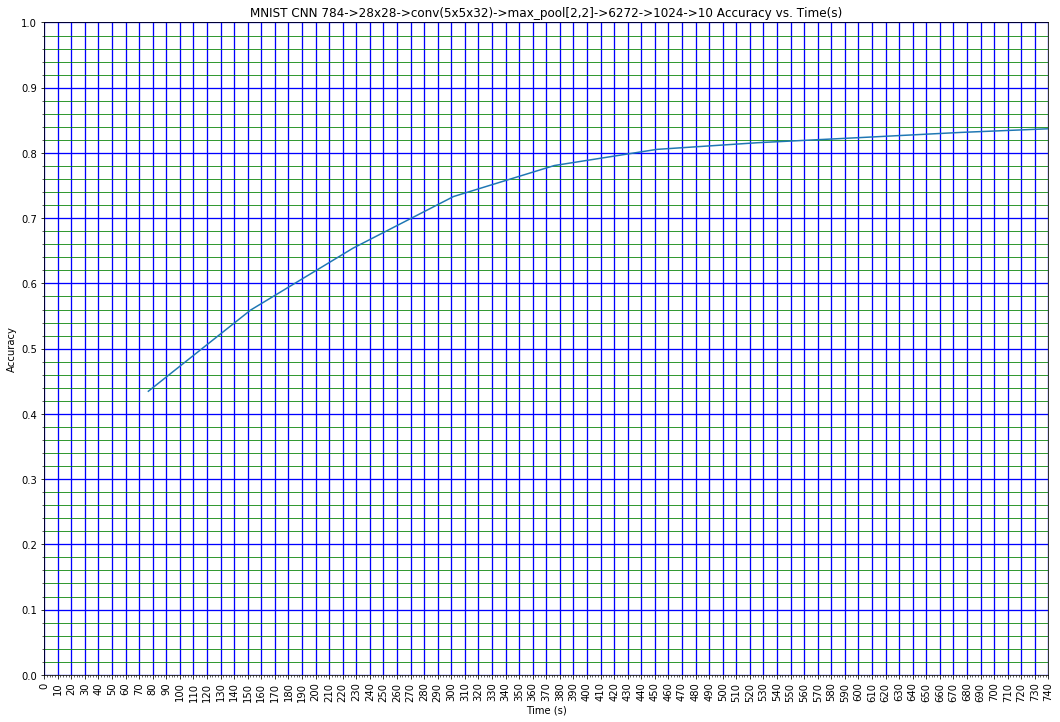

In [18]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

ax.set_title("MNIST CNN 784->28x28->conv(5x5x32)->max_pool[2,2]->6272->1024->10 Accuracy vs. Time(s)", fontsize='large')

## Set up Time x axis

ax.set_xlabel("Time (s)")
# Min x axis value is 0 (so y-axis crosses at x=0)
ax.set_xlim(left=0)
# x ticks at 10s
ax.set_xticks(np.arange(0.0,max(graph_data_time),STEPS_COUNT))
ax.xaxis.grid(which='major', color='b', linewidth=1.3)

## Set up Accuracy y axis

ax.set_ylabel("Accuracy")
ax.set_ylim(bottom=0)
# Set Accuracy tick locations and define horizontal grid lines
minorLocator = MultipleLocator(0.05)
majorLocator = MultipleLocator(0.1)
ax.yaxis.set_minor_locator(minorLocator)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.grid(which='major', color='b', linewidth=1.3)
ax.yaxis.grid(which='minor', color='g')

# Plot the chart
ax.plot(graph_data_time, graph_data_accuracy)

plt.minorticks_on()
plt.xticks(rotation=90)
plt.show(fig)